# Tackling distributions

In [1]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import math

In [2]:
year = 2021

### Play-By-Play data for 2022
df_pbp = nfl.import_pbp_data(years=[year])

### Players
df_players = nfl.import_rosters([year])
### Teams
df_teams = nfl.import_team_desc()

2021 done.
Downcasting floats.


## Solo tackles

In [3]:
df_solo_tackles = df_pbp[df_pbp['solo_tackle']==1.]

In [4]:
df_solo_tackles = df_solo_tackles.merge(df_players[["player_id", "player_name", "position", "team"]], left_on="solo_tackle_1_player_id", right_on="player_id")
df_solo_tackles = df_solo_tackles.merge(df_teams[["team_abbr", "team_color"]], left_on="team", right_on="team_abbr")

In [5]:
df_solo_tackles.groupby('player_name')['player_name'].count().sort_values()

player_name
J.P. Holtz             1
Isaiah Ford            1
Ike Boettger           1
Ian Thomas             1
Hunter Renfrow         1
                      ..
Roquan Smith          85
Devin White           87
Foyesade Oluokun      88
De'Vondre Campbell    92
Denzel Perryman       98
Name: player_name, Length: 1392, dtype: int64

In [6]:
df_team_tackles = df_solo_tackles.groupby('team')['team'].count().reset_index(name='total_solo_tackles')
df_team_tackles = df_team_tackles.merge(df_teams[["team_abbr", "team_color"]], left_on="team", right_on="team_abbr")

## Tackles per position group

In [7]:
dl_tackles = np.count_nonzero(df_solo_tackles['position']=='DL')
lb_tackles = np.count_nonzero(df_solo_tackles['position']=='LB')
db_tackles = np.count_nonzero(df_solo_tackles['position']=='DB')

In [8]:
labels = ['DL','LB', 'DB']
values = [dl_tackles, lb_tackles, db_tackles]

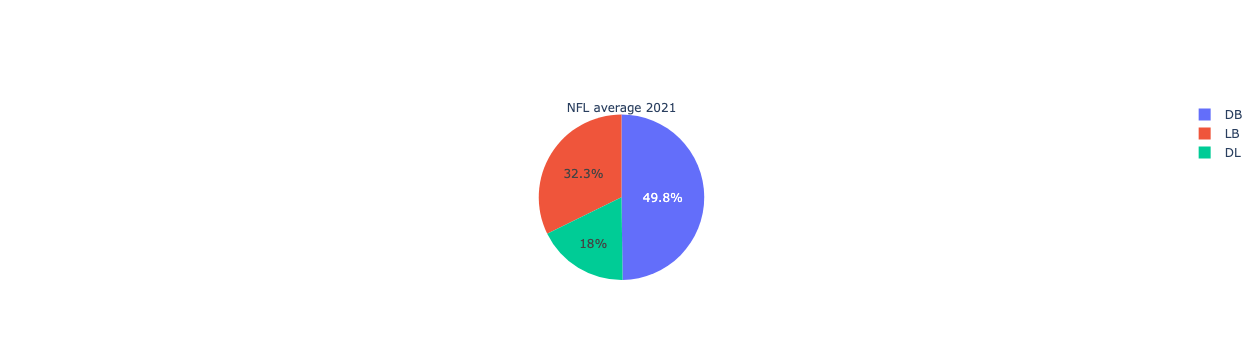

In [9]:
fig = go.Figure(data=[go.Pie(labels=labels, values=values, title=f'NFL average {year}')])
fig.show()

In [10]:
df_team_pos = df_solo_tackles.groupby(['team','position'])['position'].count()
df_pos_team = df_solo_tackles.groupby(['position','team'])['position'].count()

In [11]:
df_team_tackles = df_team_tackles.merge(df_pos_team['DB'].reset_index(name='DB_tackles'), on="team")
df_team_tackles = df_team_tackles.merge(df_pos_team['LB'].reset_index(name='LB_tackles'), on="team")
df_team_tackles = df_team_tackles.merge(df_pos_team['DL'].reset_index(name='DL_tackles'), on="team")

In [12]:
df_team_tackles.sort_values(by='DL_tackles')

team  total_solo_tackles team_abbr team_color  DB_tackles  LB_tackles  \
10  DET                 627       DET    #0076B6         305         233   
2   BAL                 610       BAL    #241773         303         213   
1   ATL                 618       ATL    #A71930         259         250   
0   ARI                 699       ARI    #97233F         350         248   
5   CHI                 629       CHI    #0B162A         275         240   
11   GB                 668        GB    #203731         306         248   
9   DEN                 601       DEN    #002244         294         206   
23  NYG                 632       NYG    #0B2265         310         205   
29   TB                 755        TB    #A71930         379         270   
17  LAC                 640       LAC    #007BC7         304         216   
30  TEN                 663       TEN    #002244         290         252   
19  MIA                 591       MIA    #008E97         288         177   
21   NE                 609        NE    #002244         297         185   
26  PIT                 711       PIT    #000000         339         232   
7   CLE                 603       CLE    #FF3C00         289         185   
4   CAR                 618       CAR    #0085CA         318         161   
12  HOU                 603       HOU    #03202F         305         169   
15   KC                 745        KC    #E31837         408         191   
16   LA                 741        LA    #003594         384         212   
14  JAX                 649       JAX    #006778         302         207   
13  IND                 626       IND    #002C5F         321         170   
24  NYJ                 623       NYJ    #003F2D         286         188   
27  SEA                 661       SEA    #002244         289         227   
25  PHI                 632       PHI    #004C54         278         214   
31  WAS                 611       WAS    #5A1414         316         147   
18   LV                 657        LV    #000000         297         209   
8   DAL                 637       DAL    #002244         324         157   
22   NO                 647        NO    #D3BC8D         319         160   
20  MIN                 613       MIN    #4F2683         295         166   
3   BUF                 656       BUF    #00338D         300         162   
6   CIN                 815       CIN    #FB4F14         394         214   
28   SF                 754        SF    #AA0000         323         195   

    DL_tackles  
10          63  
2           68  
1           81  
0           82  
5           88  
11          90  
9           90  
23          91  
29          96  
17          96  
30         100  
19         100  
21         103  
26         109  
7          111  
4          112  
12         114  
15         115  
16         117  
14         118  
13         118  
24         120  
27         120  
25         121  
31         127  
18         130  
8          136  
22         139  
20         141  
3          167  
6          171  
28         191

In [13]:
df_solo_tackles['position'].loc[~np.isin(df_solo_tackles['position'],['DL','LB','DB'])]='Other'

/var/folders/hh/2wq7ys4544ngb10v0y46_f_h0000gr/T/ipykernel_18710/2851816252.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Excluding offense or special teams players making tackles

In [14]:
df_solo_def = df_solo_tackles.loc[np.isin(df_solo_tackles['position'],['DL','LB','DB'])]

In [15]:
positions = tuple(set(df_solo_tackles['position']))

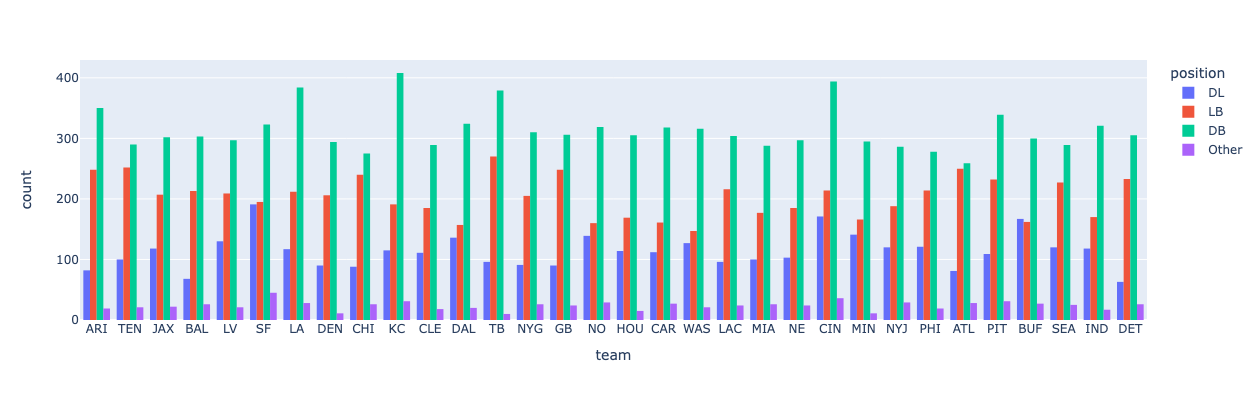

In [16]:
fig = px.histogram(df_solo_tackles, x="team",
             color='position', barmode='group', 
             height=400, category_orders=dict(position=["DL", "LB", "DB", "Other"]))
fig.show()

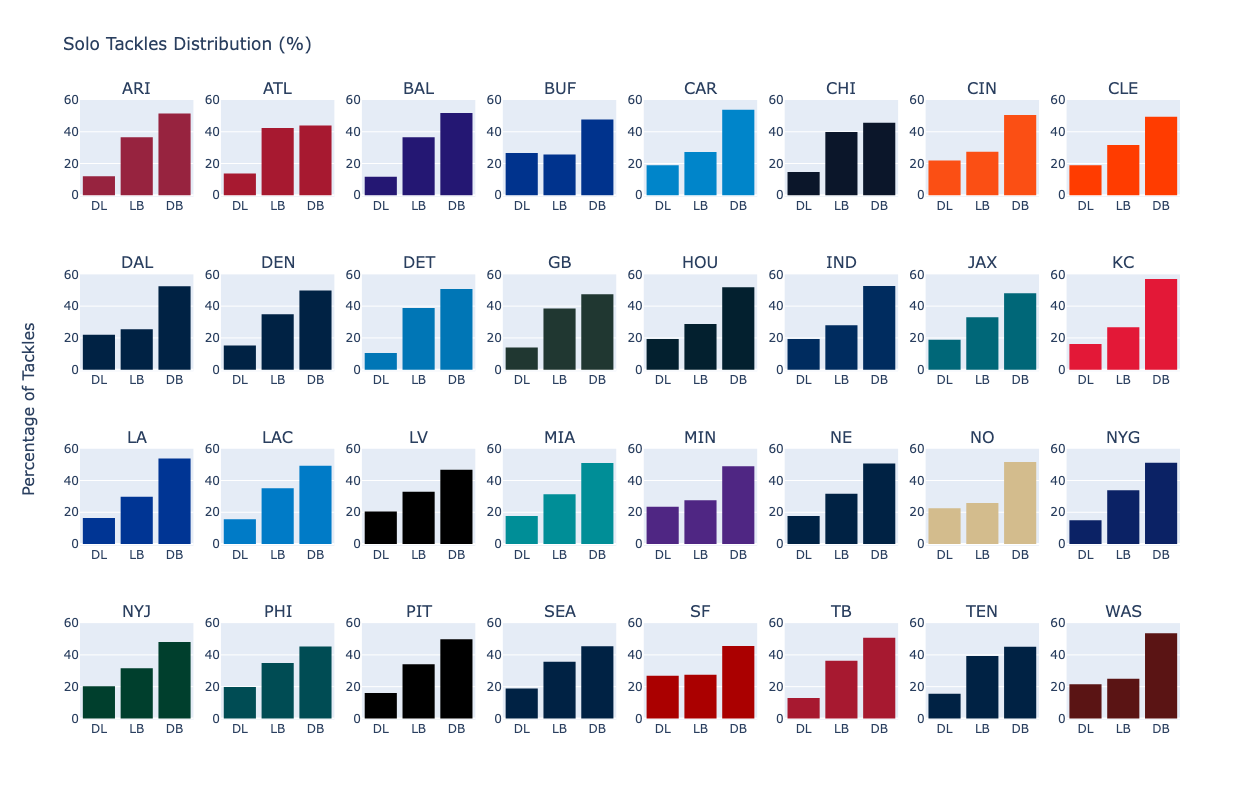

In [17]:
fig = make_subplots(rows=4, cols=8, y_title='Percentage of Tackles', subplot_titles=tuple(df_team_tackles['team'].values))

for i, team in enumerate(np.unique(df_solo_def['team'])):
    
    df_team = df_solo_def[df_solo_def['team']==team]
    df_team

    fig.add_trace(go.Histogram(
        x=df_team['position'],
        histnorm='percent',
        # name=team, # name used in legend and hover labels
        marker_color=df_team_tackles.loc[i,'team_color']
    ),row=math.floor(i/8)+1, col=i%8+1)
    
    fig.update_xaxes(row=math.floor(i/8)+1, col=i%8+1,
                     categoryorder='array', categoryarray= ["DL", "LB", "DB"])
                     # showticklabels=False)
        
    fig.update_yaxes(range=[-1, 60], row=math.floor(i/8)+1, col=i%8+1)
    
fig.update_layout(
    title_text='Solo Tackles Distribution (%)', # title of plot
    bargap=0.15, # gap between bars of adjacent location coordinates
    height=800,
    showlegend=False
)

fig.show()

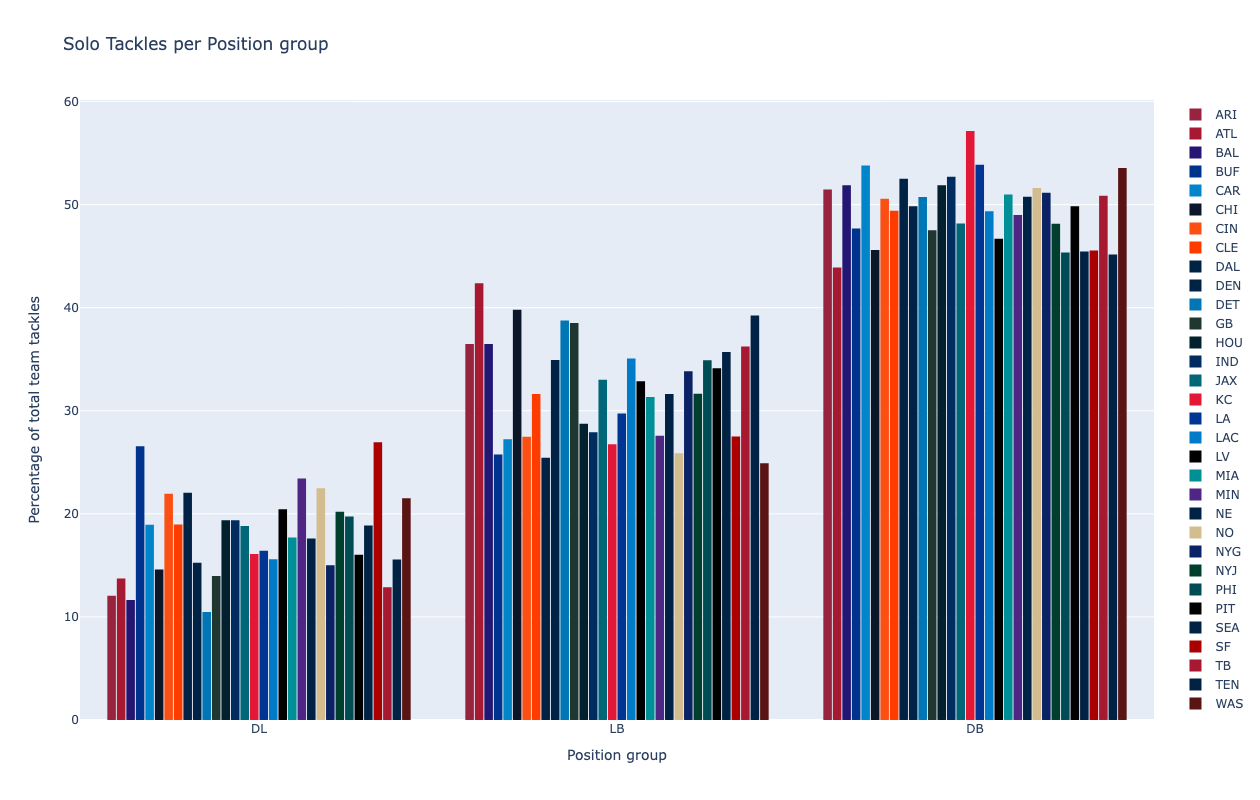

In [18]:
fig = go.Figure()

for i, team in enumerate(df_team_tackles['team'].values):
    df_team = df_solo_def[df_solo_def['team']==team]
    fig.add_trace(go.Histogram(
        x=df_team['position'],
        histnorm='percent',
        name=team, # name used in legend and hover labels
        marker_color=df_team_tackles.loc[i,'team_color']
    ))
    
fig.update_xaxes(categoryorder='array', categoryarray= ["DL", "LB", "DB"])
    
fig.update_layout(
    title_text='Solo Tackles per Position group', # title of plot
    xaxis_title_text='Position group', # xaxis label
    yaxis_title_text='Percentage of total team tackles', # yaxis label
    bargap=0.15, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
    height=800
)

fig.show()

### Single team tackle distribution

In [19]:
team_code = 'BUF'
df_st_team = df_solo_def[df_solo_def['team']==team_code]

In [20]:
teamname = df_teams['team_name'][df_teams['team_abbr']==team_code].values[0]

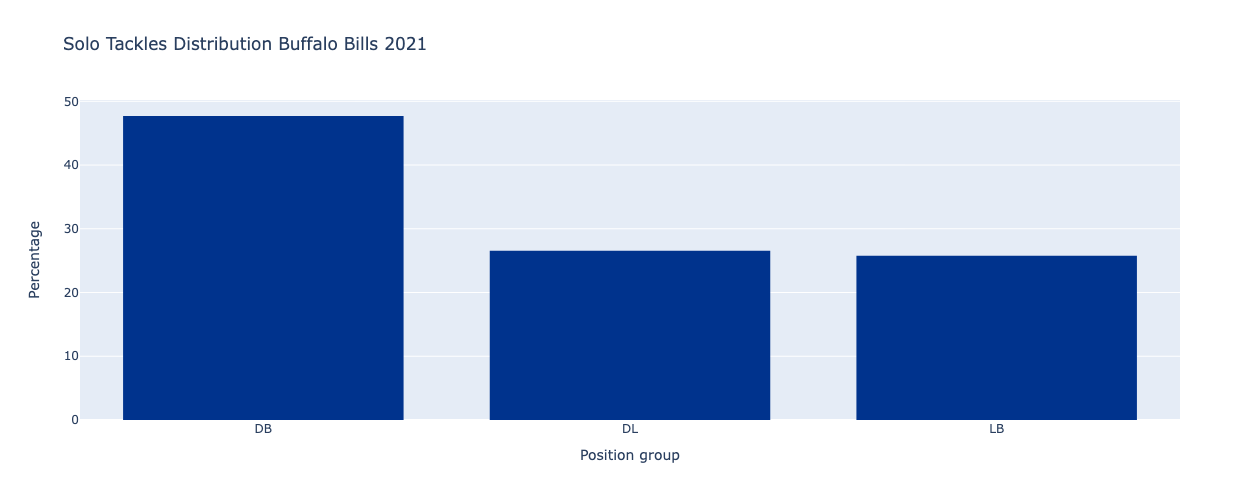

In [21]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=df_st_team['position'],
    histnorm='percent',
    # name=team, # name used in legend and hover labels
    marker_color=df_st_team['team_color'].values[0]
))

fig.update_xaxes(categoryorder='total descending')
    
fig.update_layout(
    title_text=f'Solo Tackles Distribution {teamname} {year}', # title of plot
    xaxis_title_text='Position group', # xaxis label
    yaxis_title_text='Percentage', # yaxis label
    bargap=0.15, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
    height=500
)

fig.show()

In [22]:
top_tacklers = df_st_team.groupby('player_name')["position"].count().sort_values(ascending=False)

In [23]:
top_t_pos = []
top_t_pcent = []
for i, name in enumerate(top_tacklers.index.values.astype(str)):
    top_t_pos += [tuple(set(df_st_team.loc[df_st_team['player_name']==name,'position']))[0]]
    top_t_pcent += [top_tacklers[i]/np.sum(top_tacklers.values)]

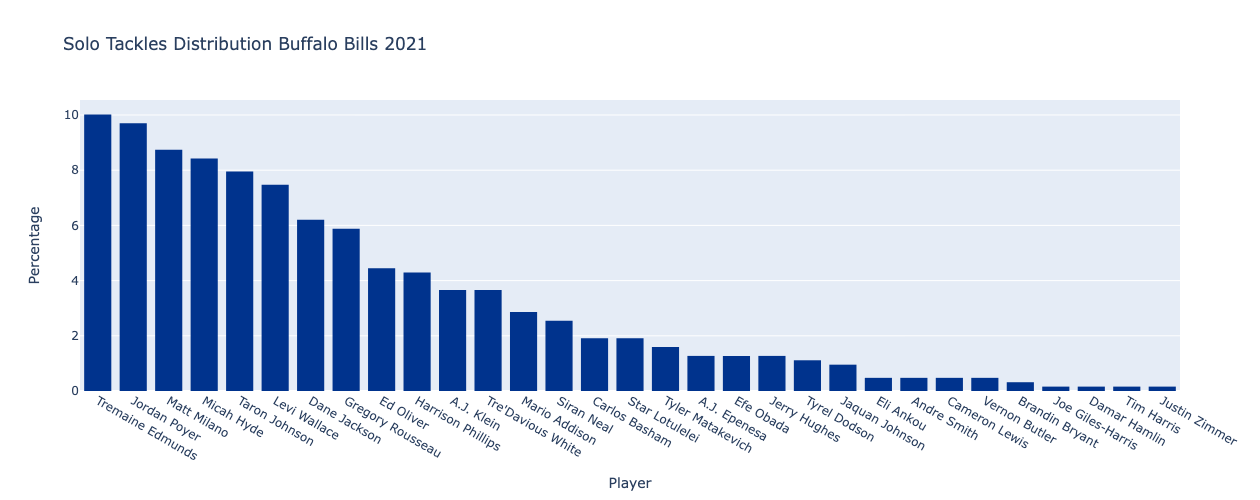

In [24]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=df_st_team['player_name'],
    histnorm='percent',
    # name=team, # name used in legend and hover labels
    marker_color=df_st_team['team_color'].values[0],
    hovertemplate =
    '<b>%{x}</b><extra></extra>' +
    '<br>'+
    '%{text}',
    text = [f'{np.round(j*100,2)} %<br>Position: <b>{i}<b>' for i,j in zip(top_t_pos, top_t_pcent)],
    texttemplate=' '
))

fig.update_xaxes(categoryorder='total descending')
    
fig.update_layout(
    title_text=f'Solo Tackles Distribution {teamname} {year}', # title of plot
    xaxis_title_text='Player', # xaxis label
    yaxis_title_text='Percentage', # yaxis label
    bargap=0.15, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
    height=500
)

fig.show()

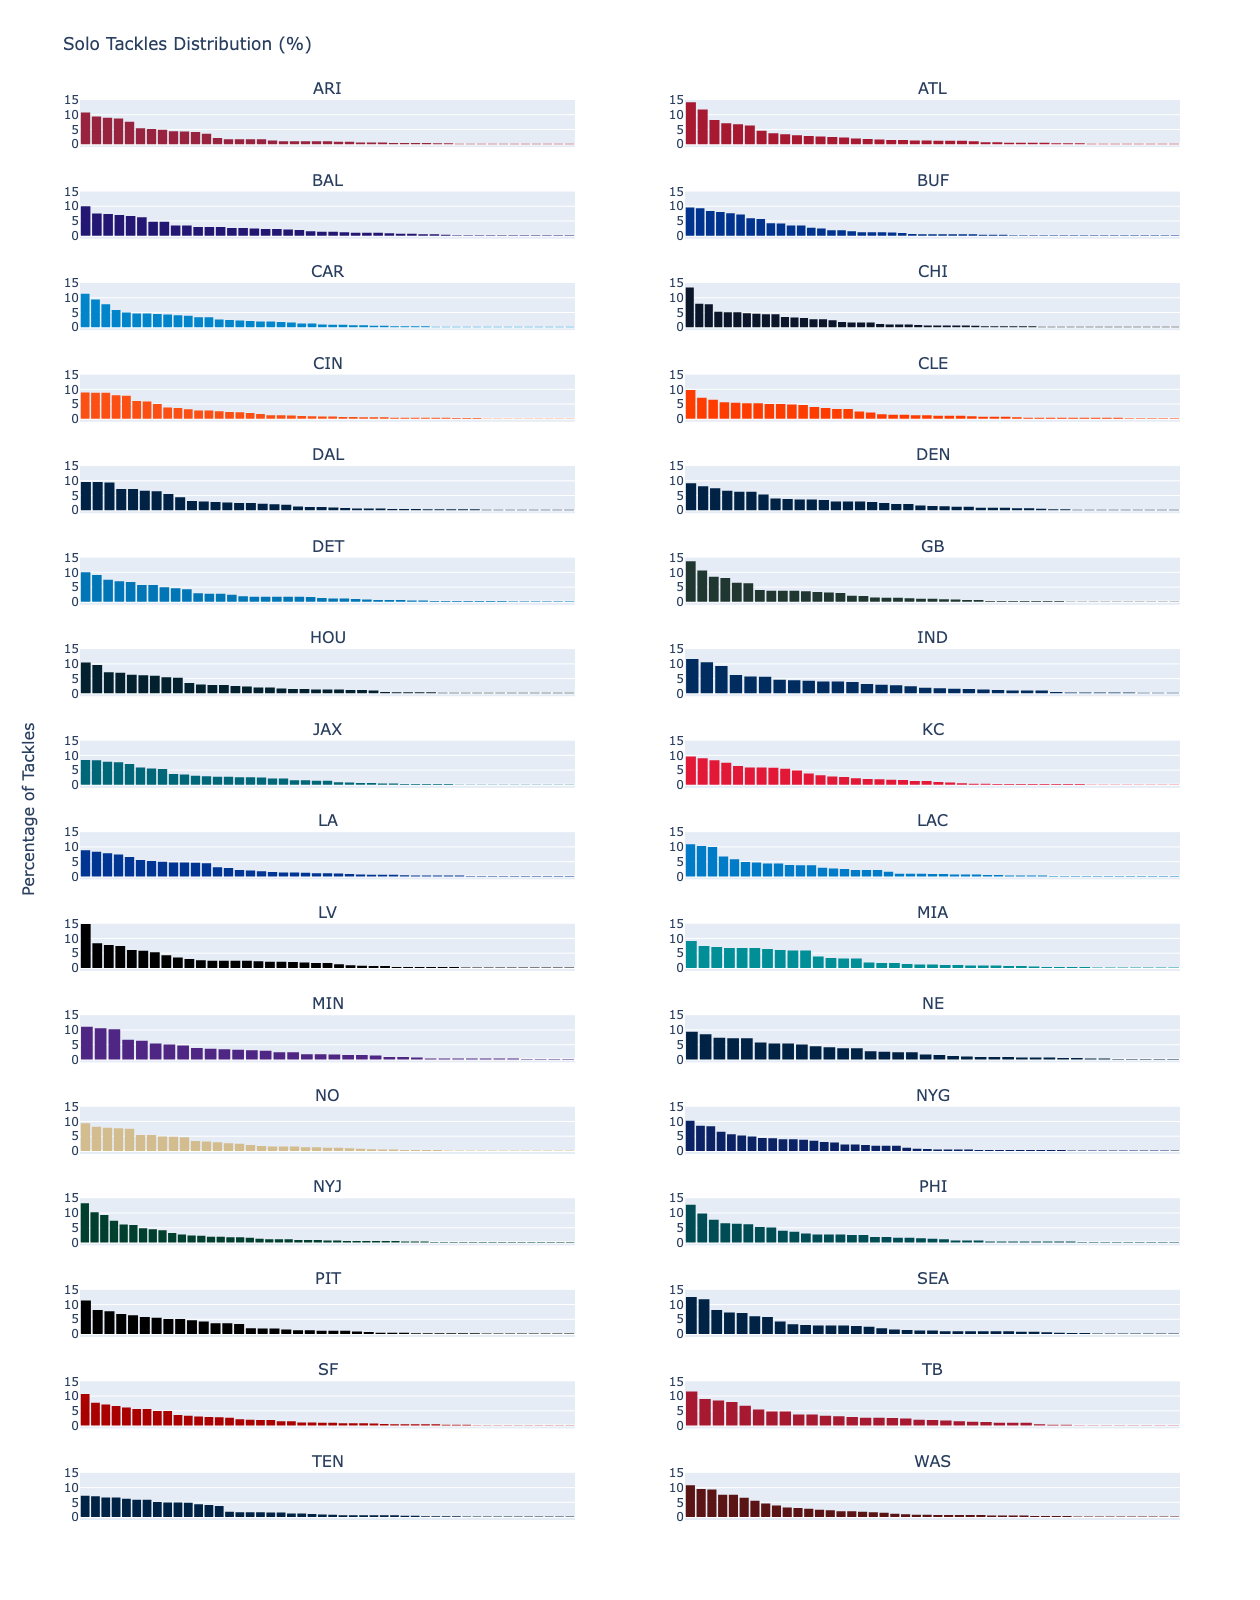

In [25]:
fig = make_subplots(rows=16, cols=2, y_title='Percentage of Tackles', subplot_titles=tuple(df_team_tackles['team'].values))

for i, team in enumerate(np.unique(df_solo_tackles['team'])):
        
    df_team = df_solo_tackles[df_solo_tackles['team']==team]
    
    top_tacklers = df_team.groupby('player_name')["position"].count().sort_values(ascending=False)
    
    top_t_pos = []
    top_t_pcent = []
    for j, name in enumerate(top_tacklers.index.values.astype(str)):
        top_t_pos += [tuple(set(df_team.loc[df_team['player_name']==name,'position']))[0]]
        top_t_pcent += [top_tacklers[j]/np.sum(top_tacklers.values)]

    fig.add_trace(go.Histogram( x=df_team['player_name'],
                                histnorm='percent',
                                # name=team, # name used in legend and hover labels
                                marker_color=df_team_tackles.loc[i,'team_color'],
                                hovertemplate = '<b>%{x}</b><extra></extra>' +
                                                '<br>'+
                                                '%{text}',
                                text = [f'{np.round(k*100,2)} %<br>Position: <b>{l}<b>' for k,l in zip(top_t_pcent, top_t_pos)],
                                texttemplate=' '),
                 row=math.floor(i/2)+1, col=i%2+1)
          
    
    fig.update_xaxes(row=math.floor(i/2)+1, col=i%2+1,
                     categoryorder='total descending',
                     showticklabels=False)
    fig.update_yaxes(range=[-1, 15], row=math.floor(i/2)+1, col=i%2+1)
    
fig.update_layout(
    title_text='Solo Tackles Distribution (%)', # title of plot
    bargap=0.15, # gap between bars of adjacent location coordinates
    height=1600,
    showlegend=False
)

fig.show()

### Versus the run

In [26]:
df_solo_tackles_run = df_pbp[np.logical_and(df_pbp['solo_tackle']==1.,df_pbp['play_type']=='run')]

In [27]:
df_solo_tackles_run = df_solo_tackles_run.merge(df_players[["player_id", "player_name", "position", "team"]], left_on="solo_tackle_1_player_id", right_on="player_id")
df_solo_tackles_run = df_solo_tackles_run.merge(df_teams[["team_abbr", "team_color"]], left_on="team", right_on="team_abbr")

In [28]:
df_solo_tackles_run.groupby('player_name')['player_name'].count().sort_values()

player_name
Kevin Peterson         1
Darren Hall            1
Darrick Forrest        1
David Moa              1
Shaka Toney            1
                      ..
C.J. Mosley           41
Minkah Fitzpatrick    42
Foyesade Oluokun      44
Denzel Perryman       47
Roquan Smith          47
Name: player_name, Length: 858, dtype: int64

In [29]:
df_team_tackles_run = df_solo_tackles_run.groupby('team')['team'].count().reset_index(name='total_solo_tackles')
df_team_tackles_run = df_team_tackles_run.merge(df_teams[["team_abbr", "team_color"]], left_on="team", right_on="team_abbr")

## Tackles per position group

In [30]:
dl_tackles_run = np.count_nonzero(df_solo_tackles_run['position']=='DL')
lb_tackles_run = np.count_nonzero(df_solo_tackles_run['position']=='LB')
db_tackles_run = np.count_nonzero(df_solo_tackles_run['position']=='DB')

In [31]:
labels = ['DL','LB', 'DB']
values = [dl_tackles_run, lb_tackles_run, db_tackles_run]

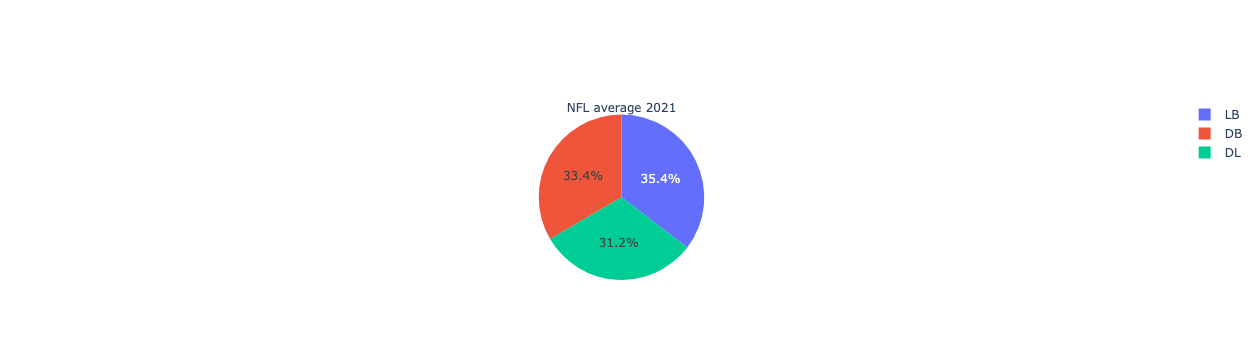

In [32]:
fig = go.Figure(data=[go.Pie(labels=labels, values=values, title=f'NFL average {year}')])
fig.show()

In [33]:
df_team_pos_run = df_solo_tackles_run.groupby(['team','position'])['position'].count()
df_pos_team_run = df_solo_tackles_run.groupby(['position','team'])['position'].count()

In [34]:
df_team_tackles_run = df_team_tackles_run.merge(df_pos_team_run['DB'].reset_index(name='DB_tackles'), on="team")
df_team_tackles_run = df_team_tackles_run.merge(df_pos_team_run['LB'].reset_index(name='LB_tackles'), on="team")
df_team_tackles_run = df_team_tackles_run.merge(df_pos_team_run['DL'].reset_index(name='DL_tackles'), on="team")

In [35]:
df_team_tackles_run.sort_values(by='DL_tackles')

team  total_solo_tackles team_abbr team_color  DB_tackles  LB_tackles  \
10  DET                 276       DET    #0076B6          90         130   
2   BAL                 217       BAL    #241773          56         103   
30  TEN                 244       TEN    #002244          75         107   
29   TB                 274        TB    #A71930         102         107   
7   CLE                 230       CLE    #FF3C00          82          81   
0   ARI                 296       ARI    #97233F         110         116   
5   CHI                 294       CHI    #0B162A          94         129   
11   GB                 265        GB    #203731          78         116   
1   ATL                 284       ATL    #A71930          83         129   
9   DEN                 259       DEN    #002244          80         106   
23  NYG                 265       NYG    #0B2265          80         110   
13  IND                 257       IND    #002C5F          98          82   
19  MIA                 223       MIA    #008E97          70          74   
4   CAR                 269       CAR    #0085CA         114          76   
26  PIT                 308       PIT    #000000         115         113   
15   KC                 287        KC    #E31837         108          97   
12  HOU                 270       HOU    #03202F         107          80   
25  PHI                 238       PHI    #004C54          71          83   
16   LA                 261        LA    #003594          91          83   
17  LAC                 288       LAC    #007BC7          97         106   
18   LV                 273        LV    #000000          85         101   
21   NE                 263        NE    #002244          83          89   
27  SEA                 252       SEA    #002244          78          83   
31  WAS                 225       WAS    #5A1414          73          62   
24  NYJ                 268       NYJ    #003F2D          84          92   
14  JAX                 282       JAX    #006778          83         107   
20  MIN                 255       MIN    #4F2683          94          68   
8   DAL                 265       DAL    #002244          94          77   
22   NO                 247        NO    #D3BC8D          80          66   
6   CIN                 299       CIN    #FB4F14          98          84   
3   BUF                 294       BUF    #00338D          99          74   
28   SF                 306        SF    #AA0000          97          83   

    DL_tackles  
10          55  
2           56  
30          62  
29          65  
7           67  
0           70  
5           71  
11          71  
1           72  
9           73  
23          75  
13          77  
19          78  
4           79  
26          80  
15          80  
12          83  
25          84  
16          85  
17          85  
18          87  
21          90  
27          90  
31          90  
24          92  
14          92  
20          93  
8           94  
22         101  
6          117  
3          121  
28         126

In [36]:
df_solo_tackles_run['position'].loc[~np.isin(df_solo_tackles_run['position'],['DL','LB','DB'])]='Other'

/var/folders/hh/2wq7ys4544ngb10v0y46_f_h0000gr/T/ipykernel_18710/3416953210.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Excluding offense or special teams players making tackles

In [37]:
df_solo_def_run = df_solo_tackles_run.loc[np.isin(df_solo_tackles_run['position'],['DL','LB','DB'])]

In [38]:
positions = tuple(set(df_solo_tackles_run['position']))

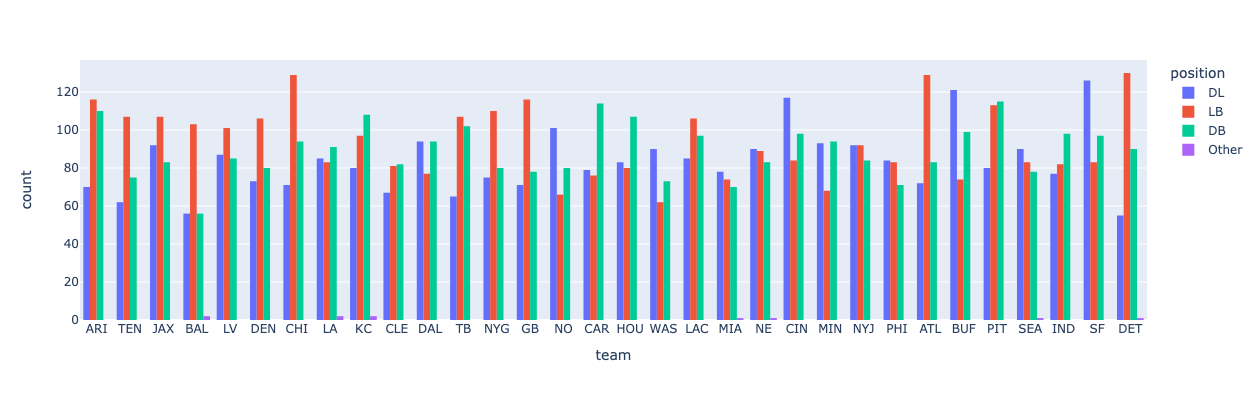

In [39]:
fig = px.histogram(df_solo_tackles_run, x="team",
             color='position', barmode='group', 
             height=400, category_orders=dict(position=["DL", "LB", "DB", "Other"]))
fig.show()

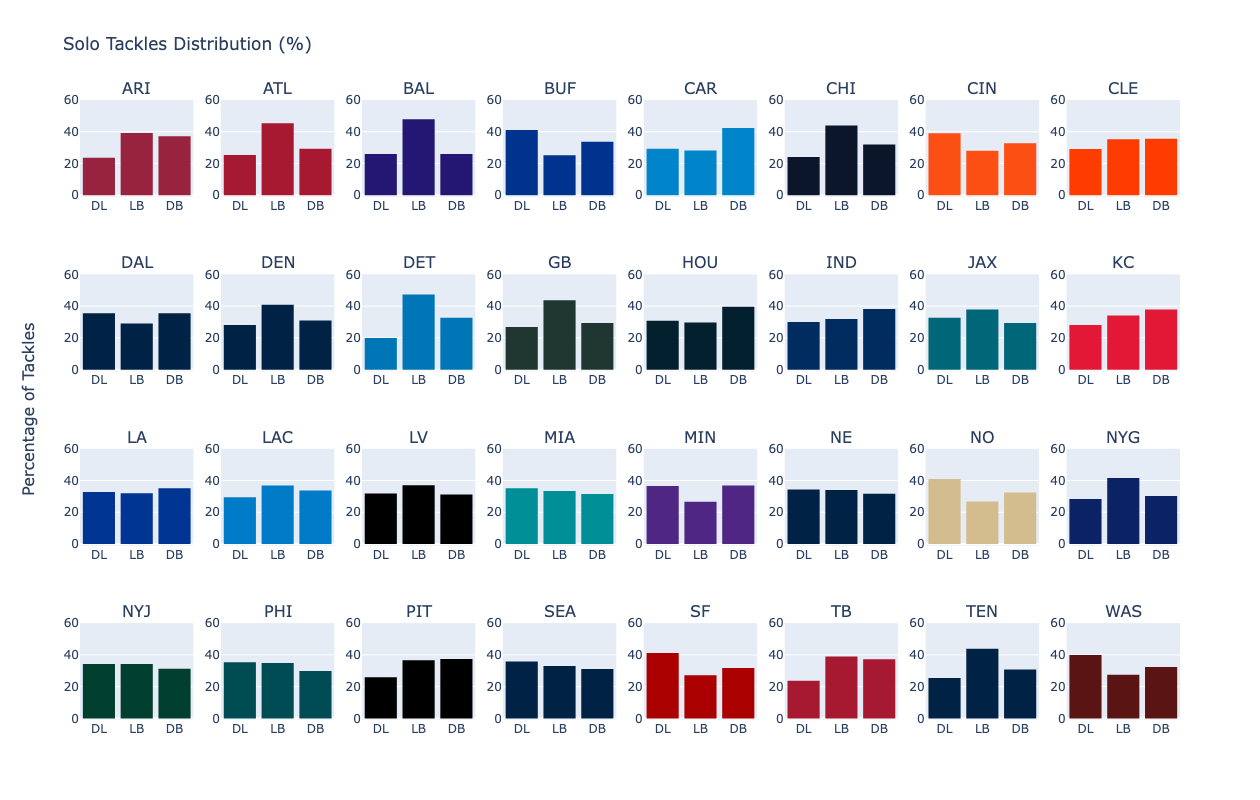

In [41]:
fig = make_subplots(rows=4, cols=8, y_title='Percentage of Tackles', subplot_titles=tuple(df_team_tackles_run['team'].values))

for i, team in enumerate(np.unique(df_solo_def_run['team'])):
    
    df_team_run = df_solo_def_run[df_solo_def_run['team']==team]

    fig.add_trace(go.Histogram(
        x=df_team_run['position'],
        histnorm='percent',
        # name=team, # name used in legend and hover labels
        marker_color=df_team_tackles_run.loc[i,'team_color']
    ),row=math.floor(i/8)+1, col=i%8+1)
    
    fig.update_xaxes(row=math.floor(i/8)+1, col=i%8+1,
                     categoryorder='array', categoryarray= ["DL", "LB", "DB"])
                     # showticklabels=False)
        
    fig.update_yaxes(range=[-1, 60], row=math.floor(i/8)+1, col=i%8+1)
    
fig.update_layout(
    title_text='Solo Tackles Distribution (%)', # title of plot
    bargap=0.15, # gap between bars of adjacent location coordinates
    height=800,
    showlegend=False
)

fig.show()

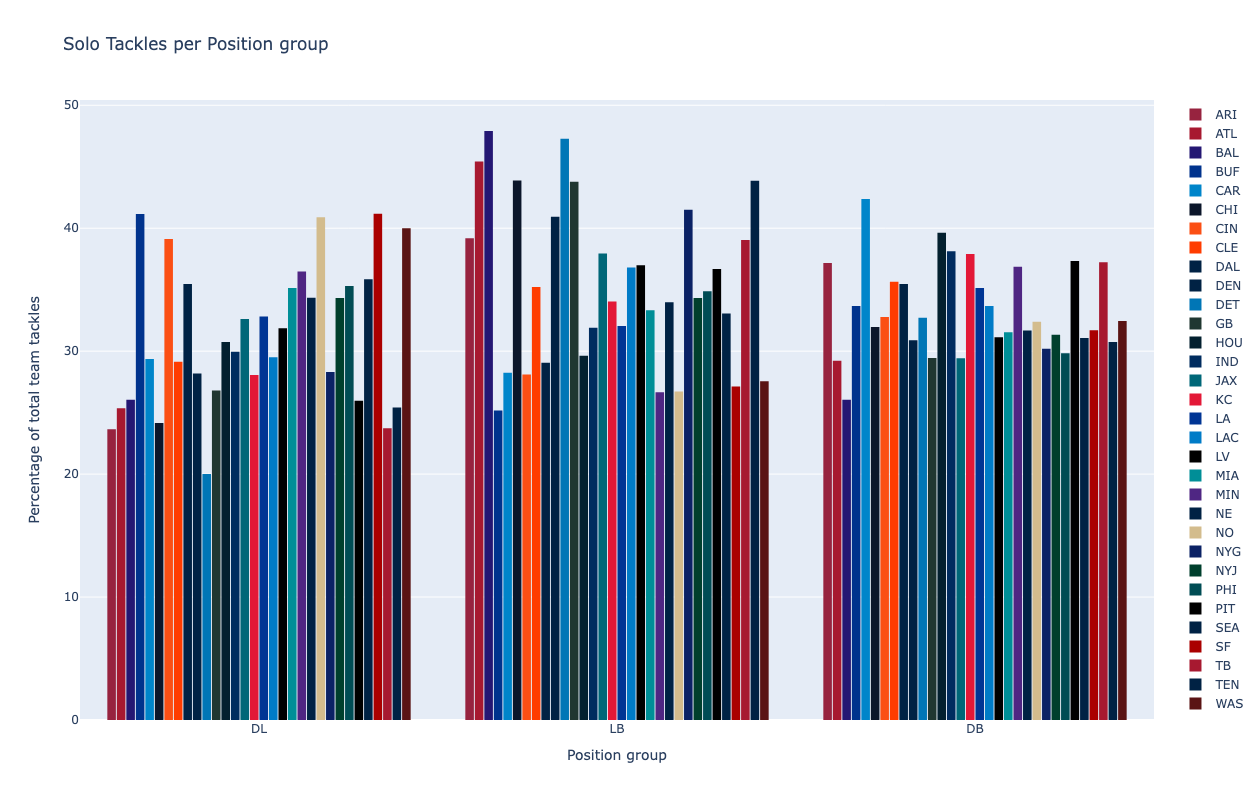

In [42]:
fig = go.Figure()

for i, team in enumerate(df_team_tackles_run['team'].values):
    df_team_run = df_solo_def_run[df_solo_def_run['team']==team]
    fig.add_trace(go.Histogram(
        x=df_team_run['position'],
        histnorm='percent',
        name=team, # name used in legend and hover labels
        marker_color=df_team_tackles_run.loc[i,'team_color']
    ))
    
fig.update_xaxes(categoryorder='array', categoryarray= ["DL", "LB", "DB"])
    
fig.update_layout(
    title_text='Solo Tackles per Position group', # title of plot
    xaxis_title_text='Position group', # xaxis label
    yaxis_title_text='Percentage of total team tackles', # yaxis label
    bargap=0.15, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
    height=800
)

fig.show()

### Single team tackle distribution

In [43]:
team_code = 'BUF'
df_st_team_run = df_solo_def_run[df_solo_def_run['team']==team_code]

In [44]:
teamname = df_teams['team_name'][df_teams['team_abbr']==team_code].values[0]

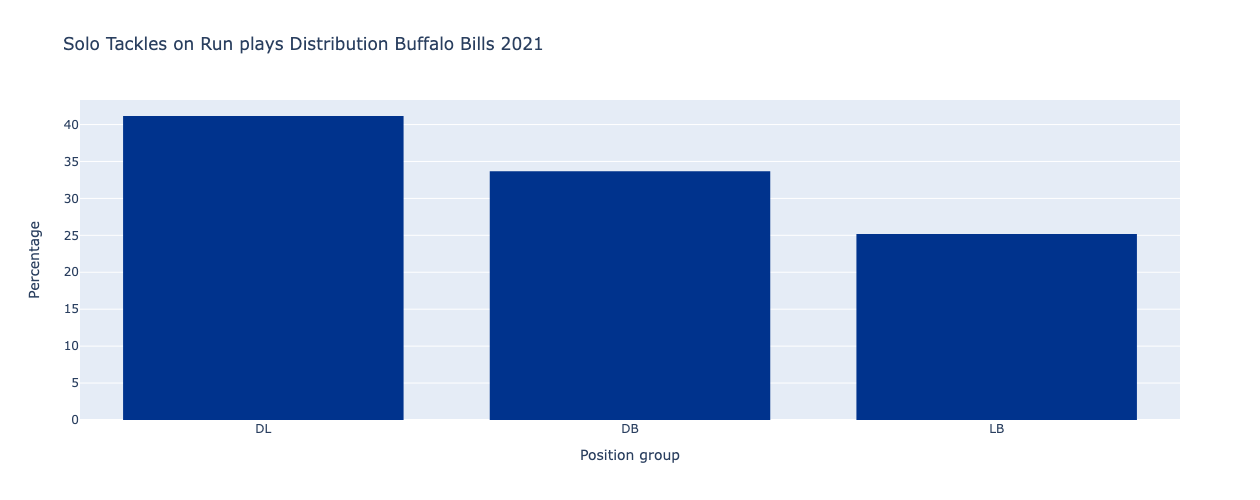

In [45]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=df_st_team_run['position'],
    histnorm='percent',
    # name=team, # name used in legend and hover labels
    marker_color=df_st_team_run['team_color'].values[0]
))

fig.update_xaxes(categoryorder='total descending')
    
fig.update_layout(
    title_text=f'Solo Tackles on Run plays Distribution {teamname} {year}', # title of plot
    xaxis_title_text='Position group', # xaxis label
    yaxis_title_text='Percentage', # yaxis label
    bargap=0.15, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
    height=500
)

fig.show()

In [49]:
top_tacklers_run = df_st_team_run.groupby('player_name')["position"].count().sort_values(ascending=False)

In [50]:
top_t_pos = []
top_t_pcent = []
for i, name in enumerate(top_tacklers_run.index.values.astype(str)):
    top_t_pos += [tuple(set(df_st_team_run.loc[df_st_team_run['player_name']==name,'position']))[0]]
    top_t_pcent += [top_tacklers_run[i]/np.sum(top_tacklers_run.values)]

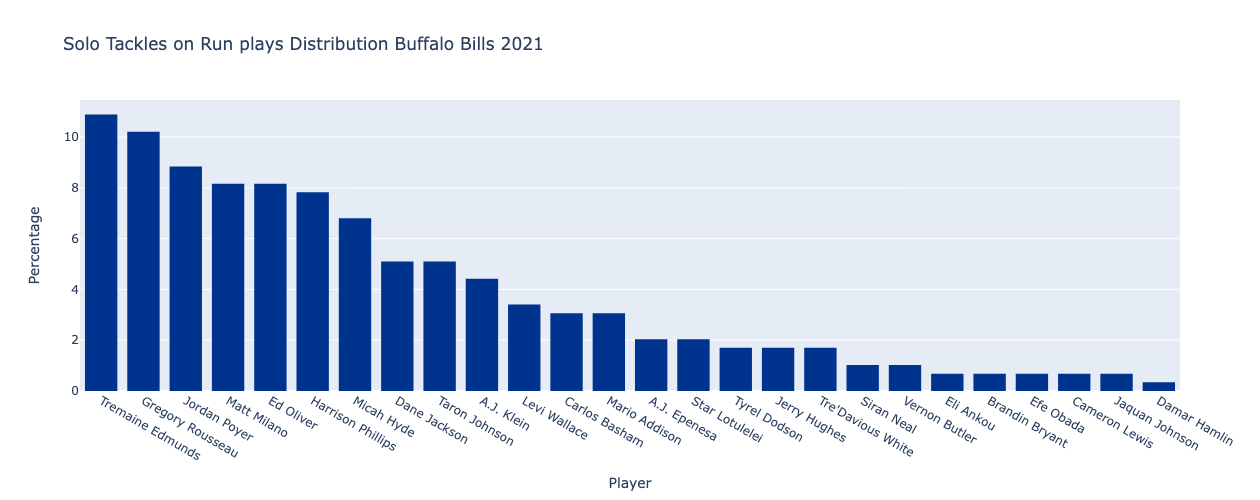

In [51]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=df_st_team_run['player_name'],
    histnorm='percent',
    # name=team, # name used in legend and hover labels
    marker_color=df_st_team_run['team_color'].values[0],
    hovertemplate =
    '<b>%{x}</b><extra></extra>' +
    '<br>'+
    '%{text}',
    text = [f'{np.round(j*100,2)} %<br>Position: <b>{i}<b>' for i,j in zip(top_t_pos, top_t_pcent)],
    texttemplate=' '
))

fig.update_xaxes(categoryorder='total descending')
    
fig.update_layout(
    title_text=f'Solo Tackles on Run plays Distribution {teamname} {year}', # title of plot
    xaxis_title_text='Player', # xaxis label
    yaxis_title_text='Percentage', # yaxis label
    bargap=0.15, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
    height=500
)

fig.show()

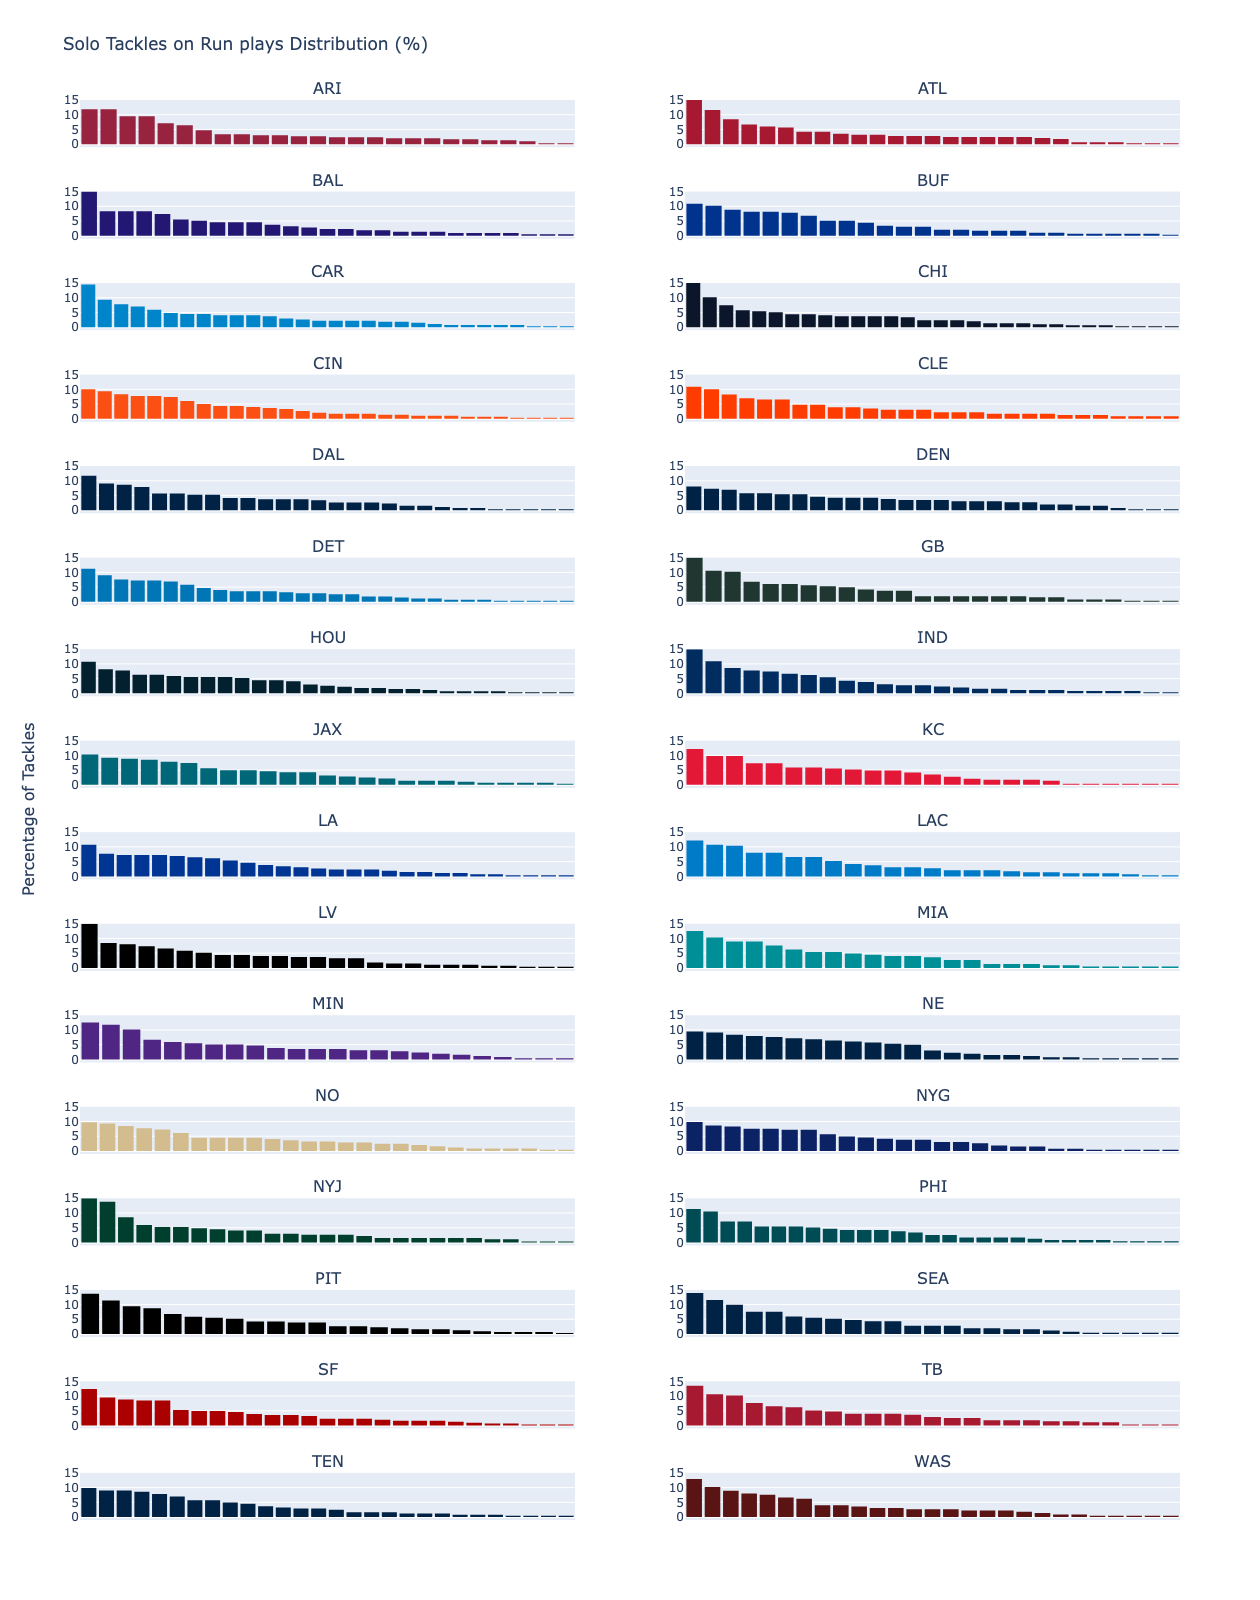

In [52]:
fig = make_subplots(rows=16, cols=2, y_title='Percentage of Tackles', subplot_titles=tuple(df_team_tackles_run['team'].values))

for i, team in enumerate(np.unique(df_solo_tackles['team'])):
        
    df_team_run = df_solo_tackles_run[df_solo_tackles_run['team']==team]
    
    top_tacklers_run = df_team_run.groupby('player_name')["position"].count().sort_values(ascending=False)
    
    top_t_pos = []
    top_t_pcent = []
    for j, name in enumerate(top_tacklers_run.index.values.astype(str)):
        top_t_pos += [tuple(set(df_team_run.loc[df_team_run['player_name']==name,'position']))[0]]
        top_t_pcent += [top_tacklers_run[j]/np.sum(top_tacklers_run.values)]

    fig.add_trace(go.Histogram( x=df_team_run['player_name'],
                                histnorm='percent',
                                # name=team, # name used in legend and hover labels
                                marker_color=df_team_tackles_run.loc[i,'team_color'],
                                hovertemplate = '<b>%{x}</b><extra></extra>' +
                                                '<br>'+
                                                '%{text}',
                                text = [f'{np.round(k*100,2)} %<br>Position: <b>{l}<b>' for k,l in zip(top_t_pcent, top_t_pos)],
                                texttemplate=' '),
                 row=math.floor(i/2)+1, col=i%2+1)
          
    
    fig.update_xaxes(row=math.floor(i/2)+1, col=i%2+1,
                     categoryorder='total descending',
                     showticklabels=False)
    fig.update_yaxes(range=[-1, 15], row=math.floor(i/2)+1, col=i%2+1)
    
fig.update_layout(
    title_text='Solo Tackles on Run plays Distribution (%)', # title of plot
    bargap=0.15, # gap between bars of adjacent location coordinates
    height=1600,
    showlegend=False
)

fig.show()